# Robust Facility Location

Consider the Facility Location Problem (FLP) that focuses on finding the best locations for facilities such as warehouses, plants, or distribution centers to minimize costs and maximize service coverage. It involves deciding where to place these facilities to effectively meet customer demands, while accounting for factors like transportation costs, facility setup costs, and capacity constraints. The goal is to determine the optimal facility locations that efficiently serve demands and maximize overall profits. The approach defined in this notebook aims to maximize profits under the condition of uncertain demand, making this a robust optimization problem.

Taking the example in [1, Section 2.4], let $ T, F, N$ be the length of the horizon, the number of candidate locations to which a facility can be assigned and the number of locations that have a demand for the facility respectively.

- $\eta \in {\bf R}$ denotes the unit price of goods 
- $c^{\rm prod}, c^{\rm stor} ,c^{\rm open} \in {\bf R}^{F}$ denotes the cost per unit of production, cost per unit capacity and the cost of opening a facility at all locations
- ${C^{\rm ship}} \in {\bf R}^{F\times N}$ denotes the cost of shipping from one location to another
- ${d^{\rm u}_t} \in {\bf R}^{N}$ denotes the uncertain demand for period $t$ at location
- $X_t \in {\bf R}^{F\times N}$ denotes the proportion of the demand at a location during period $t$ that is satisfied by a facility
- $p_t\in {\bf R}^{F}$ denotes the amount of goods that is produced at some facility at a time period $t$
- $y$ denotes whether a facility at a location is open or closed, by taking values 1 or 0, respectively
- ${z}$ denotes the capacity of the facility in this location in case it is open
- $d^*$ denotes the demand for a period in the deterministic case
 
 Let $M > 0$ be a large constant.


With this information, the uncertain linear optimization problem is formulated as: 
$$
\begin{array}{ll}
\text{maximize} & \theta \\
\text{subject to} & \sum_{\tau = 1}^T\left(\eta \cdot \mathbf{1}^T - {c^{\rm ship}} \right) \cdot \left(X_t \cdot d^{\rm u}\right) - \sum_{\tau = 1}^T(c^TP)_\tau - {c'}^T{z} - {k}^T{i} \leq \theta, \quad d^{\rm u} \in \mathcal{U} \\
                  & 1^T X_t \leq \mathbf{1}  \quad t =1,\dots,T \\
                  & \sum_{t = 1}^T X_t {d^{\rm u}} \leq \sum_{t = 1}^T 1^Tp_t \quad d^{\rm u} \in \mathcal{U} \\
                  & p_t \leq {z} \quad t =1,\dots,T \\
                  & {z} \leq My \\
                  & X_t \ge 0,\quad t=1,\dots, T\\
                  & y \in \{0, 1\}^F
\end{array}
$$

We solve this problem using the ellipsoidal uncertainty set, formulated by: 

$$ \mathcal{U}_{\text{ellips}} = \{z+d^* \ | \ \| z\|_2 \le \rho\} $$



In [27]:
import numpy as np 
import cvxpy as cp 
import lropt
import networkx as nx
import matplotlib.pyplot as plt

In the following snippet, we generate data. This example has $5$ facilities and $8$ candidate locations. The length of each horizon is $10$ and the unit price of each good is $100$.

In [46]:
np.random.seed(1)
T = 10 
F = 5   
N = 8  
M = 1100
ETA = 100.0 
RHO = 0.3

c = np.random.rand(F)
c_dash = np.random.rand(F)
k = np.random.rand(F)
d_ship = np.random.rand(F, N) #Cost of shipping from one location to another
d_star = np.random.rand(N*T)  # Deterministic demand
epsilon = np.random.rand(T)
x = {}
for i in range(F):
    x[i] = cp.Variable((N, T))
    
d_u = lropt.UncertainParameter(N*T, uncertainty_set = lropt.Ellipsoidal(b = d_star, rho = RHO)) #Flattened Uncertain Parameter - LROPT only supports one dimensional uncertain parameters
#x = cp.Variable((T,F*N), nonneg = True)  #Flattened cp.Variable - LROPT only supports two dimensional variables
p = cp.Variable((F, T), nonneg=True) 
z = cp.Variable(F)         
y = cp.Variable(F) # TODO: change it and call it "y"       
theta = cp.Variable()

P_T = p.T    


In [55]:
constraints = []

cp.sum([x[i] for i in range(F)]) <= 1
for i in range(F):
    for t in range(T):
        cp.sum([x[i][j,t] * d_u[j*T + t] for j in range(N)]) <=p[i, t]

for i in range(F):
    x[i]>=0

Next, we define all our constraints

In [30]:
revenue = cp.sum([((ETA - cp.diag(d_ship[i])) @ x[i]).flatten() @ d_u for i in range(F)])
cost_production = cp.sum(c @ p)
fixed_costs = cp.sum(cp.multiply(c_dash, z))
penalties = cp.sum(cp.multiply(k, y))

#x_reshaped = cp.reshape(x, (F, N*T)) #Reshape x for easy multiplication with d_u

constraints = [
revenue - cost_production - fixed_costs - penalties <= theta,
z <= M*y,
]

constraints.append(cp.sum([x[i] for i in range(F)]) <= 1)
for i in range(F):
    for t in range(T):
        constraints.append(cp.sum([x[i][j,t] * d_u[j*T + t] for j in range(N)]) <=p[i, t])

for i in range(F):
    constraints.append(x[i]>=0)

for t in range(T):
    constraints.append(P_T[t]<=z)

Finally, we define the objective and get the optimal value for the equation. 

In [31]:
objective = cp.Maximize(theta)
prob = lropt.RobustProblem(objective, constraints)
prob.solve(verbose = True)

/Users/mj5676/Desktop/miniconda3/envs/lropt_v3/lib/python3.12/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


                                     CVXPY                                     
                             v1.5.0.dev0+0.ffd908b                             
(CVXPY) Aug 13 12:16:42 PM: Your problem has 1554 variables, 1553 constraints, and 1 parameters.
(CVXPY) Aug 13 12:16:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 13 12:16:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 13 12:16:42 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 13 12:16:42 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Aug 13 12:16:42 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Aug 13 12:16:

In [32]:
print(f"The robust optimal value using  is {theta.value:.3E}")

TypeError: unsupported format string passed to NoneType.__format__

To compare the solution of the problem without an uncertainty parameter, the following code solves the problem in the deterministic case. 

In [ ]:
x_det = cp.Variable((F*T,N), nonneg = True) 

p = cp.Variable((F, T), nonneg=True) 
P_T = p.T    
z = cp.Variable(F)         
i = cp.Variable(F)        
epsilon = np.random.rand(T)
theta = cp.Variable()

revenue = cp.sum(cp.reshape(cp.multiply((np.tile(ETA - d_ship, (T, 1)).flatten()), x_det.flatten()), (F,N*T)) @ d_star)
cost_production = cp.sum(c @ p)
fixed_costs = cp.sum(cp.multiply(c_dash, z))
penalties = cp.sum(cp.multiply(k, i))
x_reshaped = cp.reshape(x_det, (F, N*T))

constraints = [
revenue - cost_production - fixed_costs - penalties >= theta,
cp.sum(x_det.flatten()) <= 1,
x_det.flatten()>=0,
z <= M*i,
cp.sum(x_reshaped @ d_star) <=cp.sum(p)
]

for t in range(T):
    constraints.append(P_T[t]<=z)

objective = cp.Maximize(theta)
prob = lropt.RobustProblem(objective, constraints)
prob.solve()
print(f"The deterministic optimal value using is {theta.value:.3E}")


The deterministic optimal value using is 9.957E+01


This is a facility - network graph created using the robust optimal value of $x$.

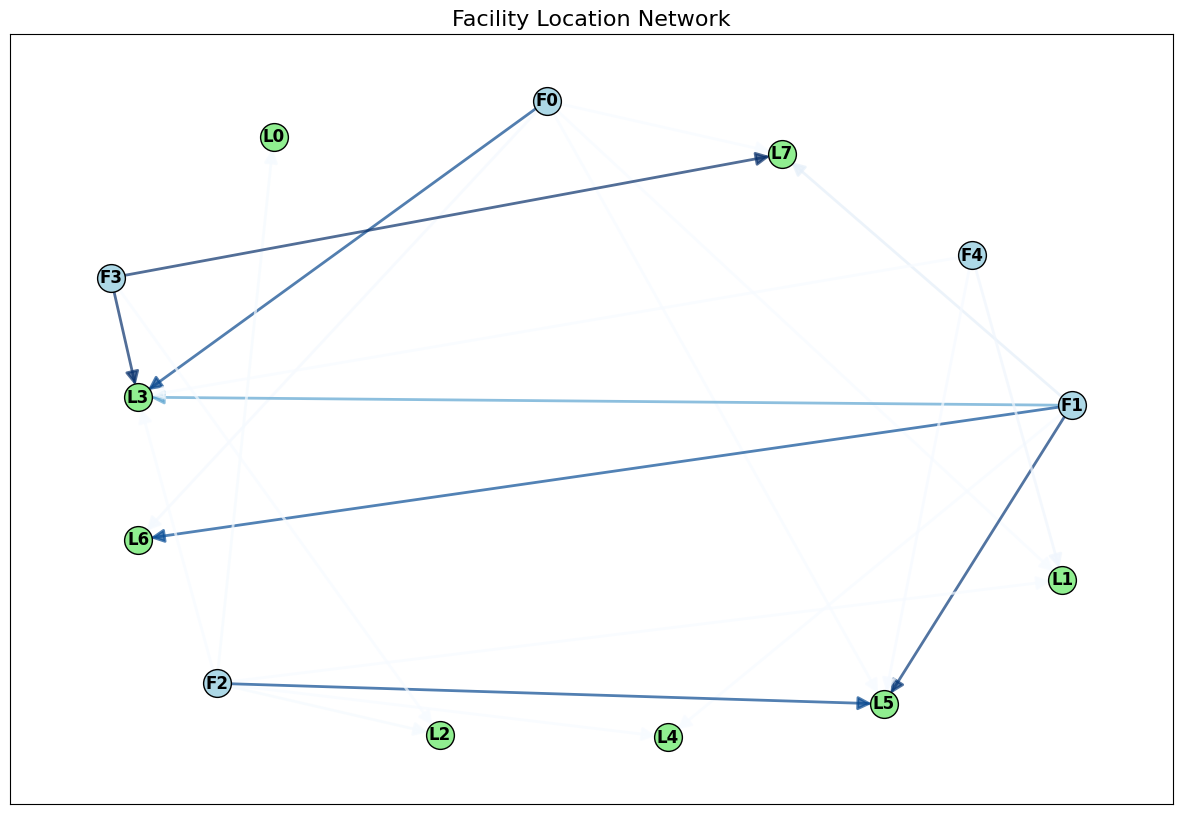

In [ ]:
x_opt = x.value

G = nx.DiGraph()


facility_nodes = range(F)
location_nodes = range(F, F + N)


G.add_nodes_from(facility_nodes, bipartite=0)
G.add_nodes_from(location_nodes, bipartite=1)


for i in range(F):
    for j in range(N):
        if x_opt[i * T, j] > 0:
            G.add_edge(i, F + j, weight=x_opt[i * T, j])


pos = nx.spring_layout(G, seed=42) 
fig, ax = plt.subplots(figsize=(15, 10))
nx.draw_networkx_nodes(G, pos, nodelist=facility_nodes, node_color='lightblue', node_size=400, edgecolors='k', node_shape='o')
nx.draw_networkx_nodes(G, pos, nodelist=location_nodes, node_color='lightgreen', node_size=400, edgecolors='k', node_shape='o')


edges = G.edges(data=True)
edge_weights = [data['weight'] for u, v, data in edges]


edge_weights = np.array(edge_weights)
edge_colors = edge_weights


nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, alpha=0.7, edge_color=edge_colors, edge_cmap=plt.cm.Blues, arrows=True, arrowsize=20)
nx.draw_networkx_labels(G, pos, labels={i: f"F{i}" for i in facility_nodes}, font_size=12, font_weight='bold', verticalalignment='center')
nx.draw_networkx_labels(G, pos, labels={F + j: f"L{j}" for j in range(N)}, font_size=12, font_weight='bold', verticalalignment='center')
plt.rcParams.update({"font.size": 18})
plt.title('Facility Location Network', fontsize=16)
plt.show()

## References

1. Bertsimas, Dimitris, and Dick Den Hertog. Robust and Adaptive Optimization. [Dynamic Ideas LLC], 2022.